# Validate Born Raytracing Against Theory

This notebook processes a Gower Street N-body simulation through a Born-approximation
raytracing pipeline with DES Y3 n(z), and validates the output convergence power spectra
against CAMB theory predictions.

**Prerequisites:** Run `bash scripts/download_data.sh` to download sim00001 and the DES Y3 FITS file.

In [1]:
import os, sys
sys.path.insert(0, "..")

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

from lensing.io import load_sim_params, load_shell_info, load_des_y3_nz, get_valid_shell_ids
from lensing.cosmology import setup_camb, get_theory_cls
from lensing.raytracing import compute_lensing_weights, born_raytrace
from lensing.validation import measure_all_cls, plot_validation, plot_ratio, plot_convergence_maps

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

## 1. Load simulation parameters

In [2]:
cosmo = load_sim_params("../gower_street_runs.csv", sim_id=1)
print("Cosmological parameters for sim00001:")
for k, v in cosmo.items():
    print(f"  {k:12s} = {v}")

Cosmological parameters for sim00001:
  Omega_m      = 0.2900404837
  sigma_8      = 0.7657514029
  w            = -1.008941473
  Omega_bh2    = 0.02236562735
  h            = 0.6673620556
  n_s          = 0.949651544
  m_nu         = 0.06
  Omega_b      = 0.0502178441


## 2. Load shell info and DES Y3 n(z)

In [3]:
SIM_DIR = "../data/sim00001"
FITS_PATH = "../data/2pt_NG_final_2ptunblind_02_26_21_wnz_maglim_covupdate.fits"

shell_info = load_shell_info(SIM_DIR)
print(f"Number of shells: {len(shell_info)}")
print(f"Redshift range: {shell_info['z_near'].min():.3f} to {shell_info['z_far'].max():.3f}")
print(f"Chi range (Mpc/h): {shell_info['chi_near'].min():.1f} to {shell_info['chi_far'].max():.1f}")

valid_ids = get_valid_shell_ids(SIM_DIR)
print(f"Valid shell count: {len(valid_ids)}")

Number of shells: 100
Redshift range: -0.000 to 49.000
Chi range (Mpc/h): -0.0 to 8470.5
Valid shell count: 77


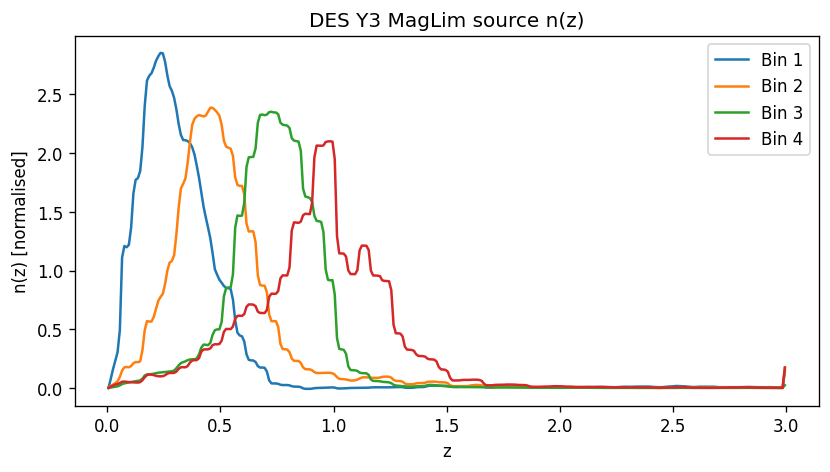

In [4]:
z_nz, nz_bins = load_des_y3_nz(FITS_PATH)

fig, ax = plt.subplots(figsize=(8, 4))
for i in range(4):
    ax.plot(z_nz, nz_bins[i], label=f"Bin {i+1}")
ax.set_xlabel("z")
ax.set_ylabel("n(z) [normalised]")
ax.legend()
ax.set_title("DES Y3 MagLim source n(z)")
plt.show()

## 3. Compute lensing weights

Weight array shape: (4, 100)  (n_bins x n_shells)


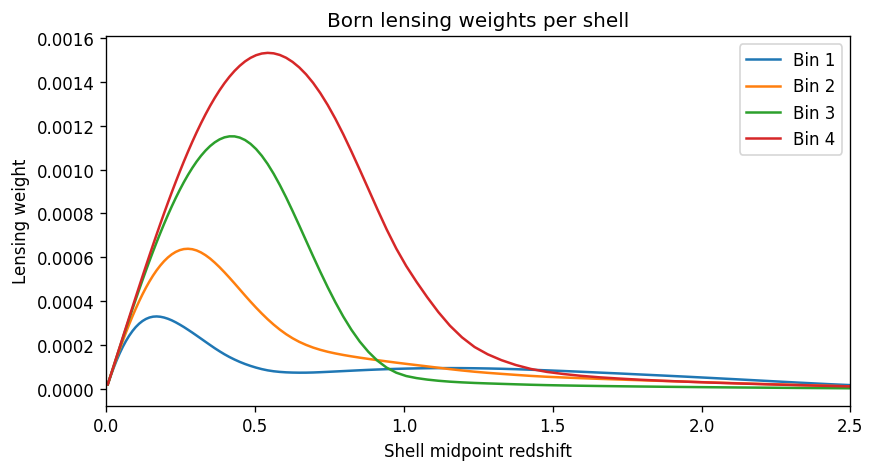

In [20]:
weights = compute_lensing_weights(shell_info, z_nz, nz_bins, cosmo)
print(f"Weight array shape: {weights.shape}  (n_bins x n_shells)")

fig, ax = plt.subplots(figsize=(8, 4))
for i in range(4):
    ax.plot(shell_info['z_mid'], weights[i], label=f"Bin {i+1}")
ax.set_xlabel("Shell midpoint redshift")
ax.set_xlim(0, 2.5)
ax.set_ylabel("Lensing weight")
ax.legend()
ax.set_title("Born lensing weights per shell")
plt.show()

## 4. Born raytracing

In [13]:
NSIDE_OUT = 1024
KAPPA_CACHE = "../data/kappa_maps.npy"

if os.path.exists(KAPPA_CACHE):
    print(f"Loading cached kappa maps from {KAPPA_CACHE}")
    kappa_maps = list(np.load(KAPPA_CACHE))
else:
    print(f"Running Born raytracing (nside_out={NSIDE_OUT})...")
    kappa_maps = born_raytrace(SIM_DIR, shell_info, weights, nside_out=NSIDE_OUT)
    np.save(KAPPA_CACHE, np.array(kappa_maps))
    print(f"Saved to {KAPPA_CACHE}")

print("Done.")
for i, km in enumerate(kappa_maps):
    print(f"  Bin {i+1}: mean={km.mean():.2e}, std={km.std():.4f}, min={km.min():.4f}, max={km.max():.4f}")

Running Born raytracing (nside_out=1024)...
  Shell    24 (z=2.029): done
  Shell    25 (z=1.945): done
  Shell    26 (z=1.866): done
  Shell    27 (z=1.792): done
  Shell    28 (z=1.722): done
  Shell    29 (z=1.657): done
  Shell    30 (z=1.594): done
  Shell    31 (z=1.535): done
  Shell    32 (z=1.480): done
  Shell    33 (z=1.426): done
  Shell    34 (z=1.376): done
  Shell    35 (z=1.328): done
  Shell    36 (z=1.281): done
  Shell    37 (z=1.237): done
  Shell    38 (z=1.195): done
  Shell    39 (z=1.155): done
  Shell    40 (z=1.116): done
  Shell    41 (z=1.078): done
  Shell    42 (z=1.042): done
  Shell    43 (z=1.008): done
  Shell    44 (z=0.974): done
  Shell    45 (z=0.942): done
  Shell    46 (z=0.911): done
  Shell    47 (z=0.881): done
  Shell    48 (z=0.852): done
  Shell    49 (z=0.823): done
  Shell    50 (z=0.796): done
  Shell    51 (z=0.770): done
  Shell    52 (z=0.744): done
  Shell    53 (z=0.719): done
  Shell    54 (z=0.695): done
  Shell    55 (z=0.671): d

## 5. Convergence maps

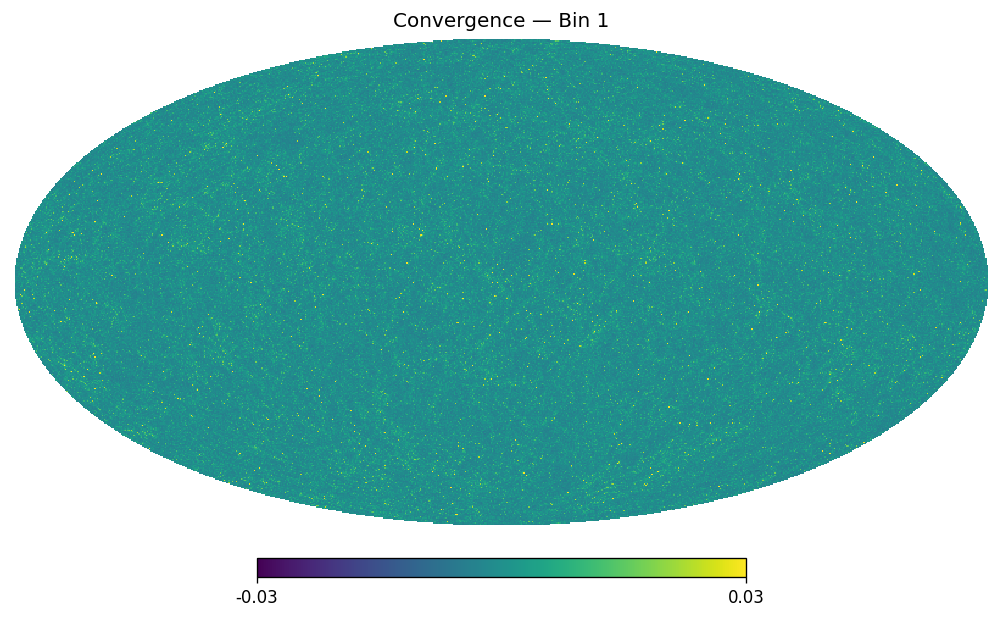

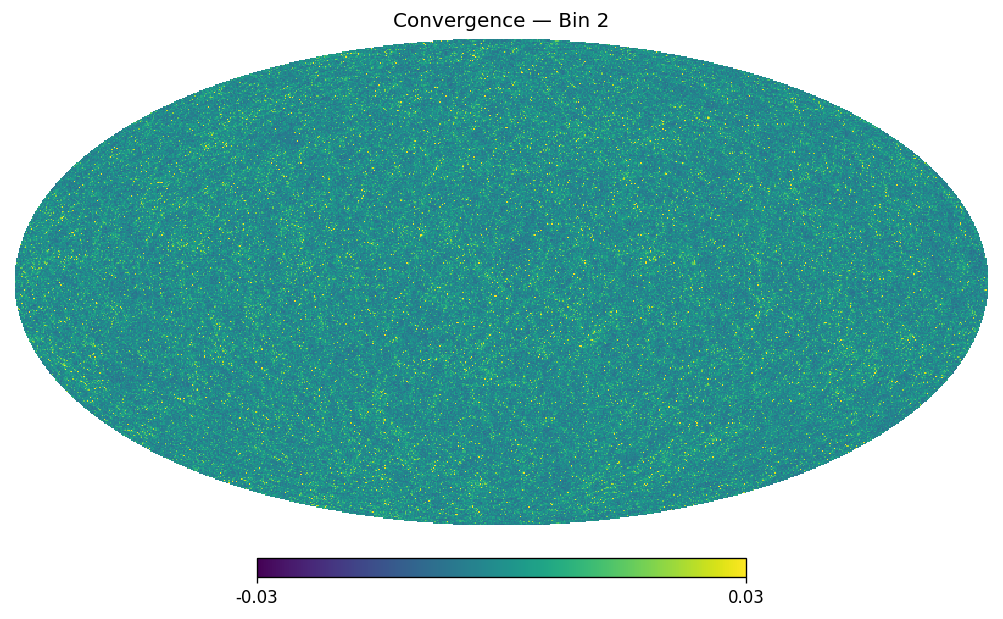

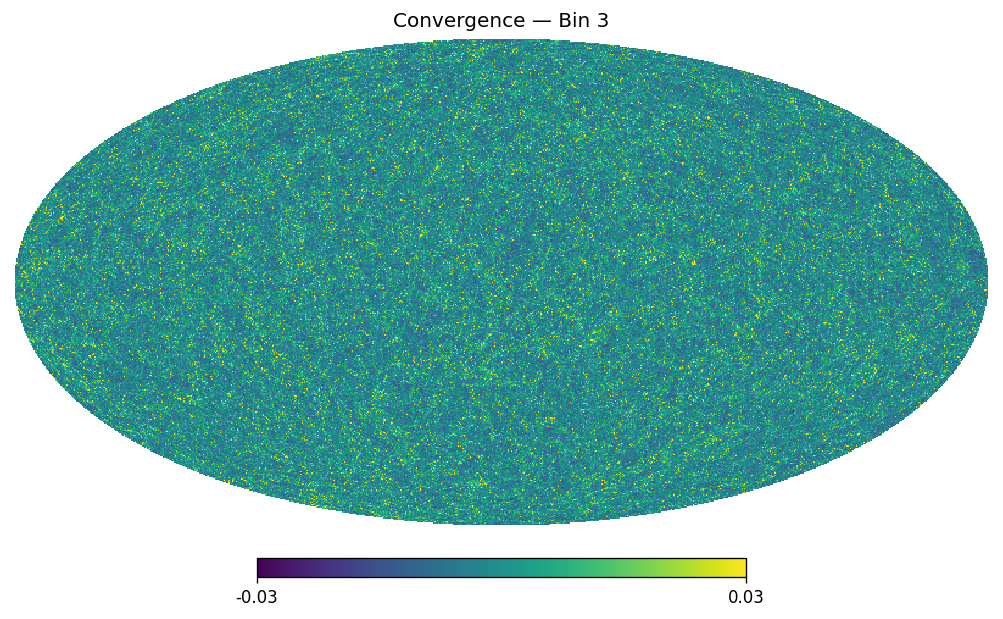

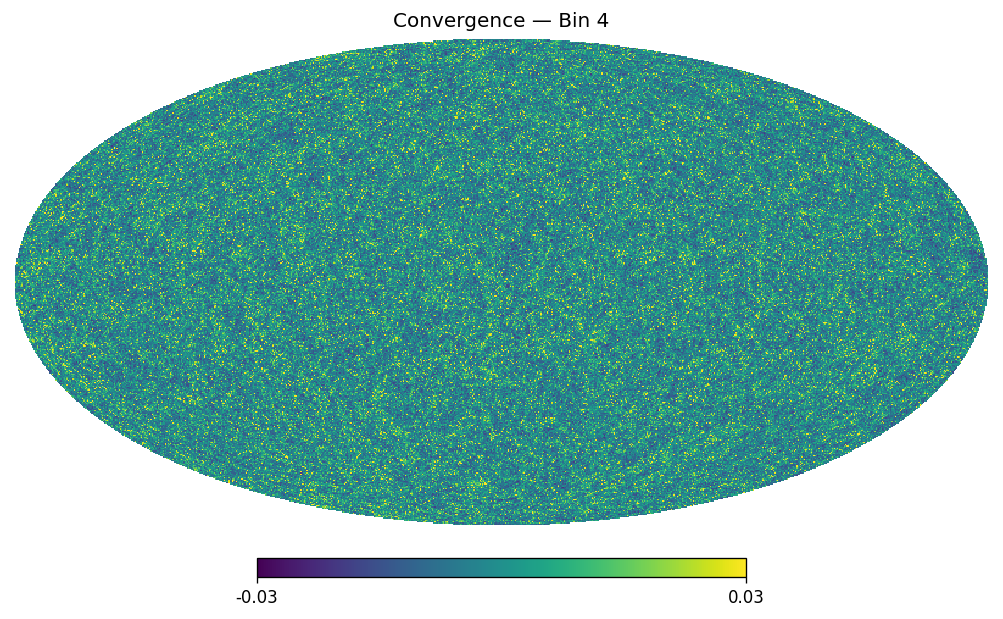

In [14]:
for i in range(4):
    hp.mollview(kappa_maps[i], title=f"Convergence — Bin {i+1}", min=-0.03, max=0.03)
    plt.show()

## 6. CAMB theory power spectra

In [15]:
LMAX = 3 * NSIDE_OUT - 1

print(f"Computing CAMB theory C_ell up to lmax={LMAX}...")
results = setup_camb(cosmo, z_nz, nz_bins, lmax=LMAX)
theory_cls = get_theory_cls(results, lmax=LMAX)
print(f"Got {len(theory_cls)} spectra.")

Computing CAMB theory C_ell up to lmax=3071...
Got 10 spectra.


## 7. Measure power spectra from maps

In [16]:
measured_cls = measure_all_cls(kappa_maps, lmax=LMAX)
print(f"Measured {len(measured_cls)} spectra up to lmax={LMAX}.")

Measured 10 spectra up to lmax=3071.


## 8. Validation: Measured vs Theory

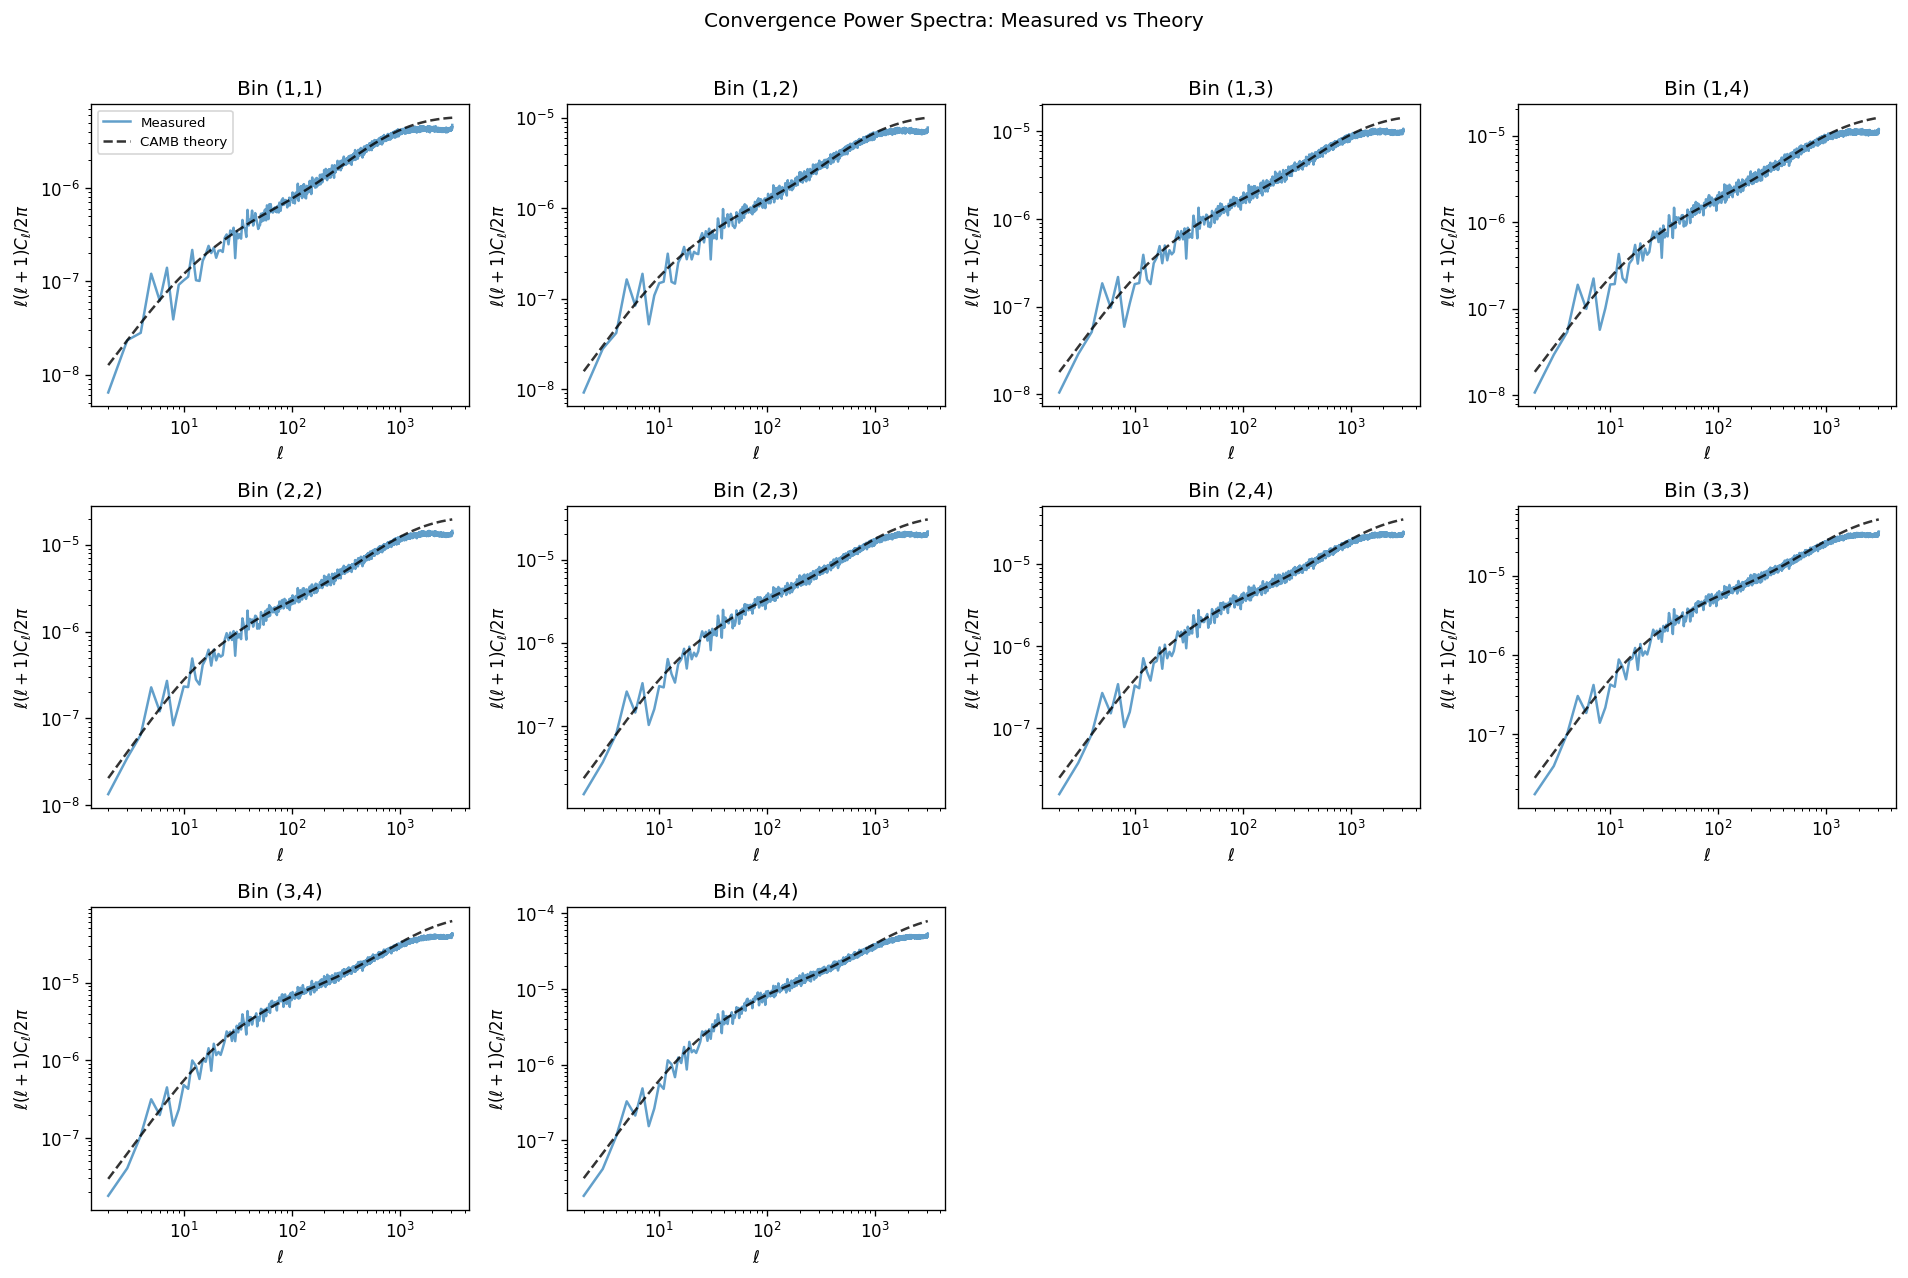

In [17]:
fig = plot_validation(measured_cls, theory_cls, lmax=LMAX)
plt.show()

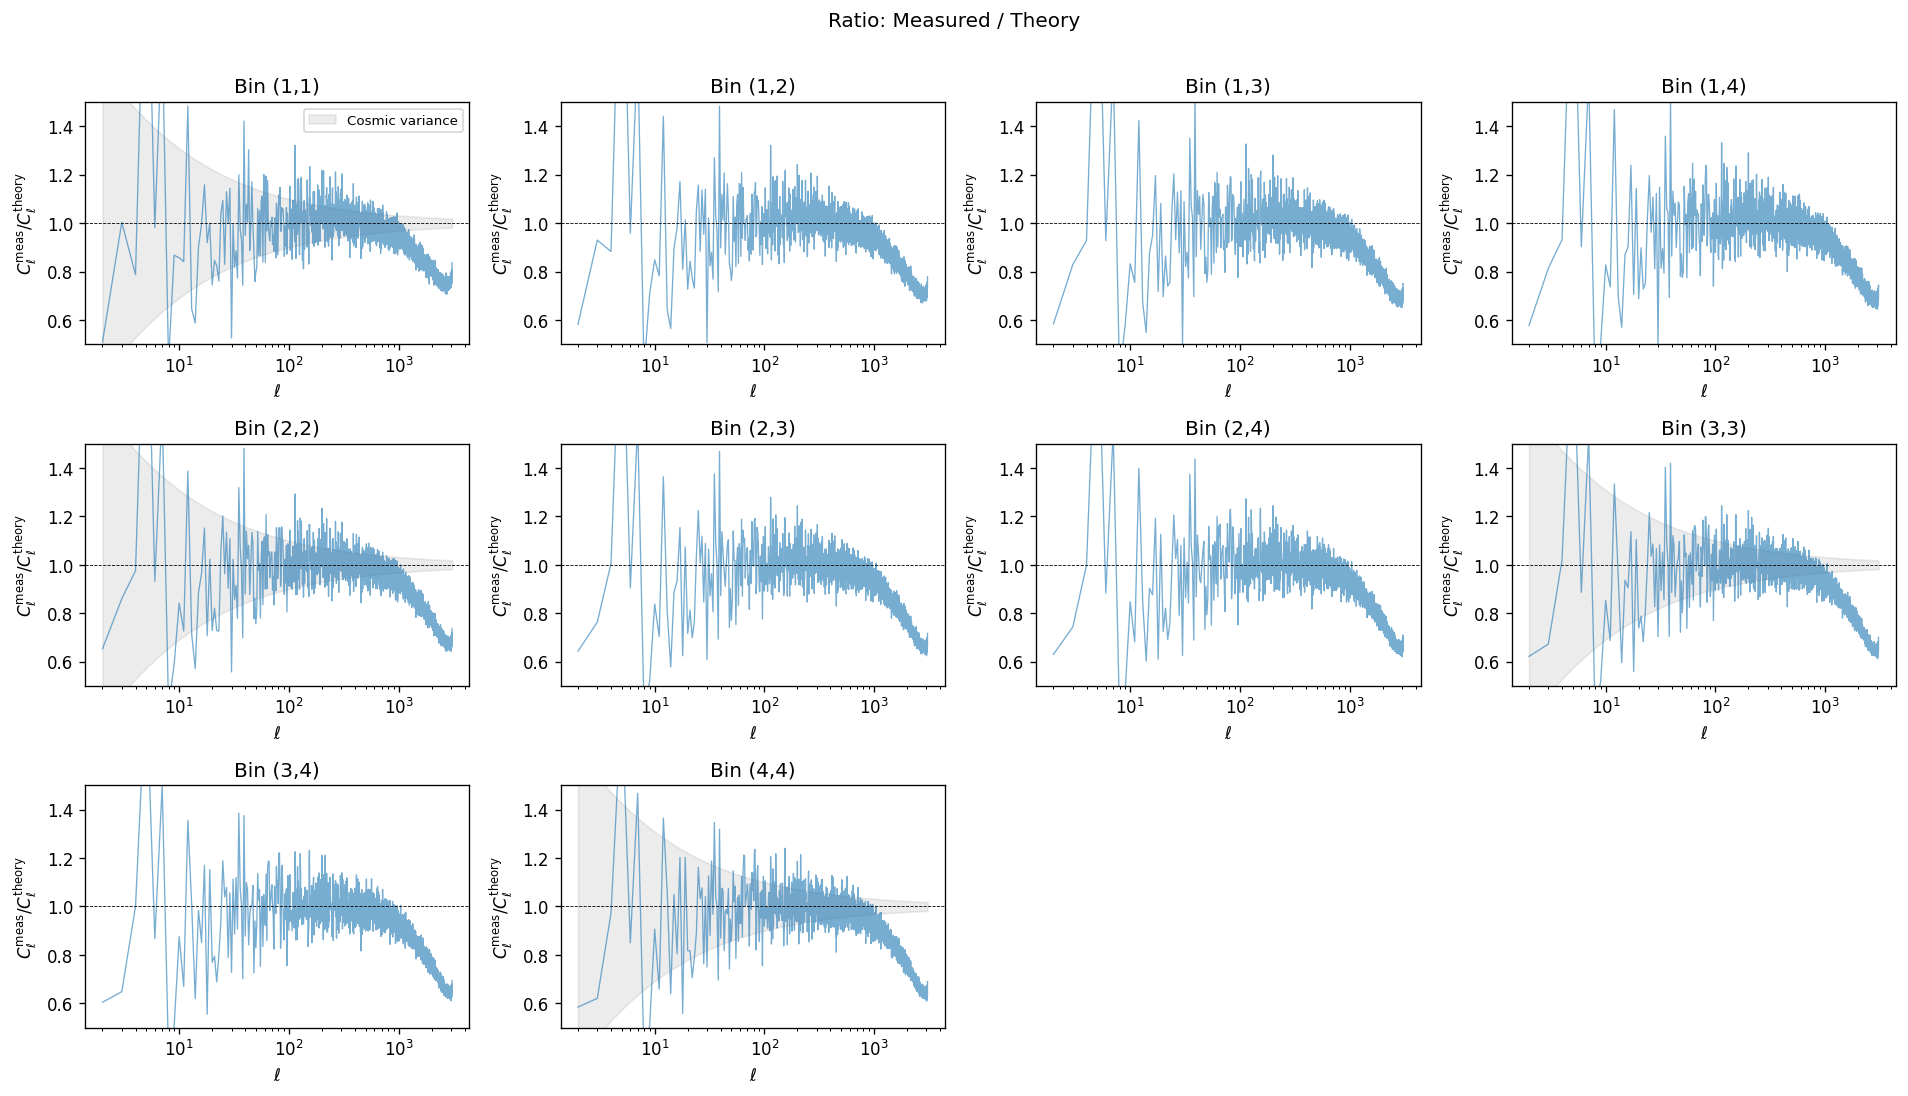

In [18]:
fig = plot_ratio(measured_cls, theory_cls, lmax=LMAX)
plt.show()

In [19]:
print("Measured / Theory ratio at selected multipoles:\n")
print(f"{'Bin pair':<12s} {'ell=50':>8s} {'ell=100':>8s} {'ell=200':>8s} {'ell=500':>8s} {'ell=1000':>8s}")
print("-" * 56)
for (i, j) in sorted(measured_cls.keys()):
    label = f"({i+1},{j+1})"
    vals = []
    for ell in [50, 100, 200, 500, 1000]:
        t = theory_cls[(i, j)][ell]
        m = measured_cls[(i, j)][ell]
        vals.append(f"{m/t:.3f}" if t > 0 else "  N/A")
    print(f"{label:<12s} {'  '.join(vals)}")

Measured / Theory ratio at selected multipoles:

Bin pair       ell=50  ell=100  ell=200  ell=500 ell=1000
--------------------------------------------------------
(1,1)        0.797  0.986  1.217  1.066  0.943
(1,2)        0.763  0.945  1.241  1.069  0.939
(1,3)        0.756  0.903  1.281  1.080  0.942
(1,4)        0.776  0.879  1.290  1.075  0.941
(2,2)        0.756  0.912  1.234  1.064  0.936
(2,3)        0.770  0.891  1.243  1.070  0.940
(2,4)        0.793  0.886  1.244  1.064  0.940
(3,3)        0.802  0.893  1.223  1.070  0.946
(3,4)        0.829  0.902  1.211  1.063  0.947
(4,4)        0.857  0.918  1.186  1.051  0.948
